In [1]:
import os
from pathlib import Path
from PIL import Image
# import geopandas as gpd
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from my_functions_new import *
from my_plotting_functions import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Define whether to filter out values <0.1
remove_little_values = True

model_directory = '../../../../FloodModelling/MeganModel_New/'

### Plot the clusters

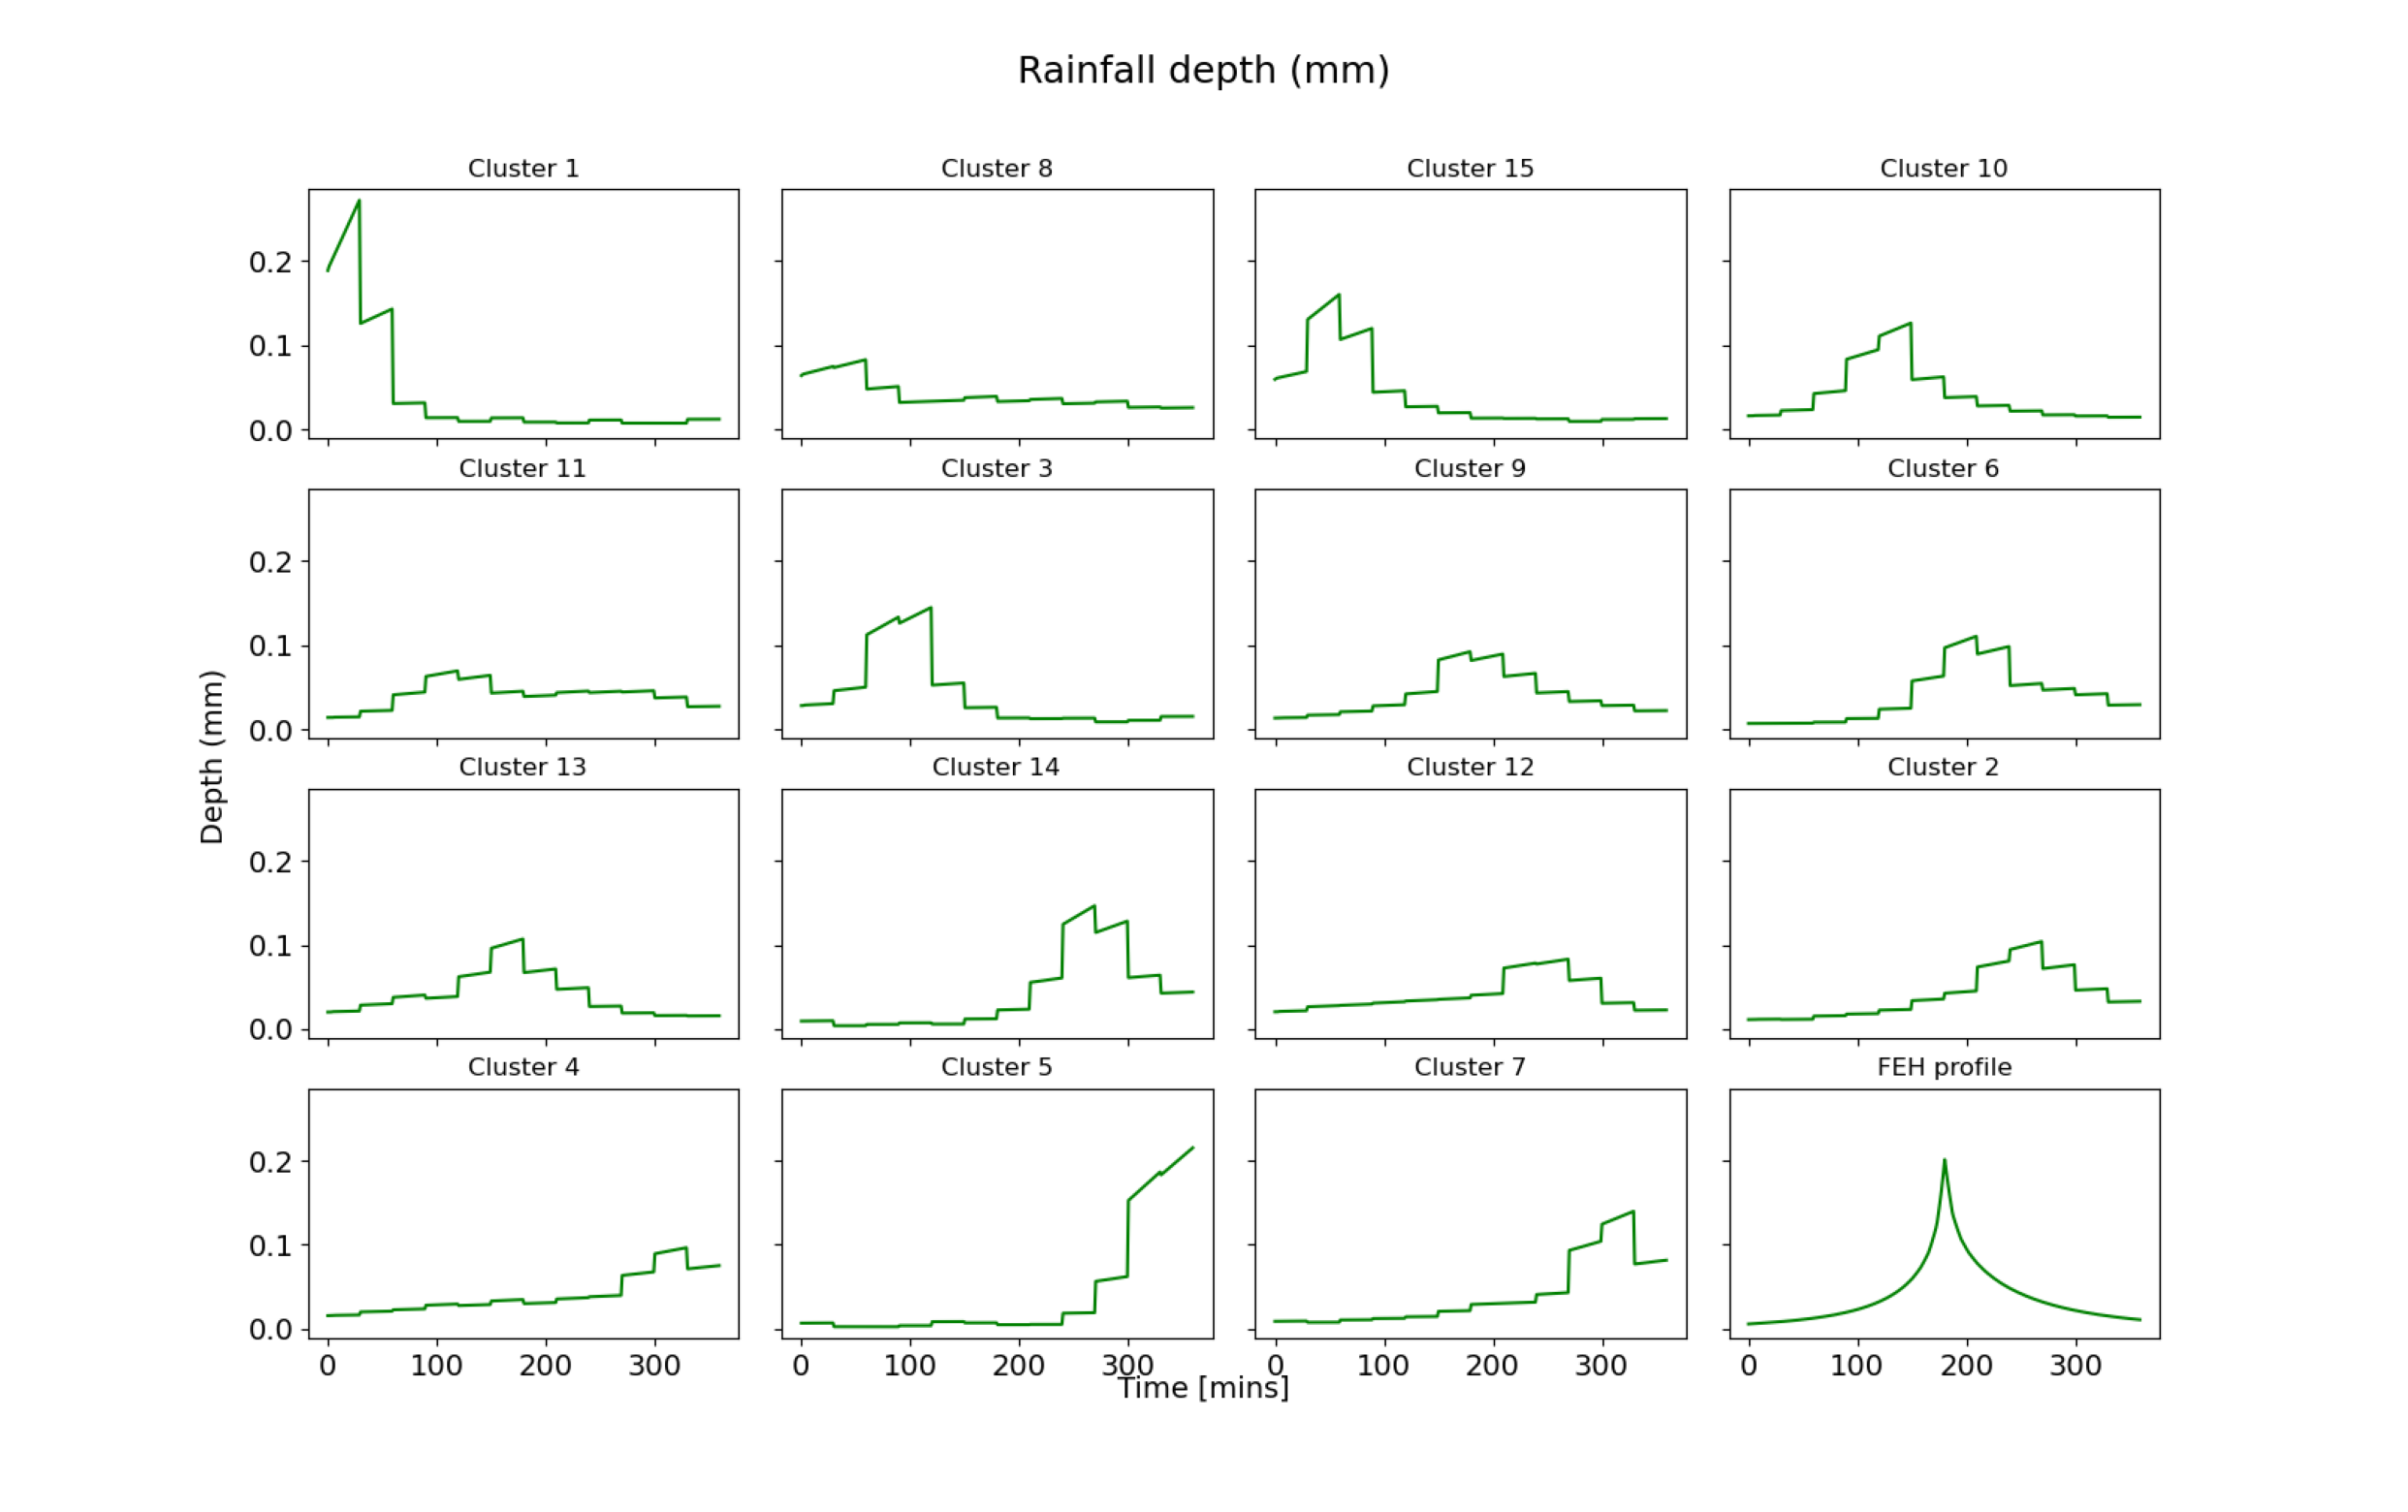

In [2]:
fig,ax =plt.subplots(figsize=(40,20))
img = Image.open("../../CreateSyntheticRainfallEvents/ObservedProfiles/6hr_100yrRP/PostLossRemoval/clusters_ordered_by_loadingstyle.png")
plt.axis('off')
plt.imshow(img);

### Define the names of the method (shorter and longer versions)

In [3]:
short_ids = ['6h_sp','6h_c1','6h_c2','6h_c3','6h_c4', '6h_c5', '6h_c6','6h_c7',
            '6h_c8','6h_c9', '6h_c10', '6h_c11','6h_c12','6h_c13','6h_c14', '6h_c15']   
methods = ['6h_single-peak', 'Cluster1', 'Cluster2', 'Cluster3', 'Cluster4', 'Cluster5', 'Cluster6', 'Cluster7', 'Cluster8',
           'Cluster9','Cluster10', 'Cluster11',  'Cluster12','Cluster13', 'Cluster14', 'Cluster15']  
# Ordered by the minute of the max rainfall intensity
short_ids_by_loading = ['6h_sp','6h_c1','6h_c8','6h_c15','6h_c3','6h_c11','6h_c10','6h_c9','6h_c13','6h_c6',
 '6h_c2','6h_c12','6h_c14','6h_c4','6h_c7','6h_c5']
short_ids_by_intensity = ['6h_sp','6h_c1','6h_c5','6h_c15','6h_c14','6h_c3','6h_c7','6h_c10','6h_c6','6h_c13',
 '6h_c2','6h_c4','6h_c9','6h_c12','6h_c8','6h_c11']

### Read in summary results from Processing-2.ipynb script

In [17]:
cluster_results= pd.read_csv("allclusters_summary.csv")

# Relationship between the number of flooded cells in urban and non-urban areas

27% of the catchment is classified as either urban or semi-urban.     
Changes to the extent, depth and velocity of flooding in these areas are the most important.  
Therefore, it is important to determine whether any of the rainfall scenarios result in a greater proportion of the flooding taking part in these urban areas.  

The plots below show the relationship between the flooded area and the urban flooded area. There is a fairly consistent relationship across all the scenarios, with between 33 and 35% of the flooding being in urban areas. 

In [5]:
# cluster_results['UrbanFloodedArea'] /cluster_results['TotalFloodedArea'] 

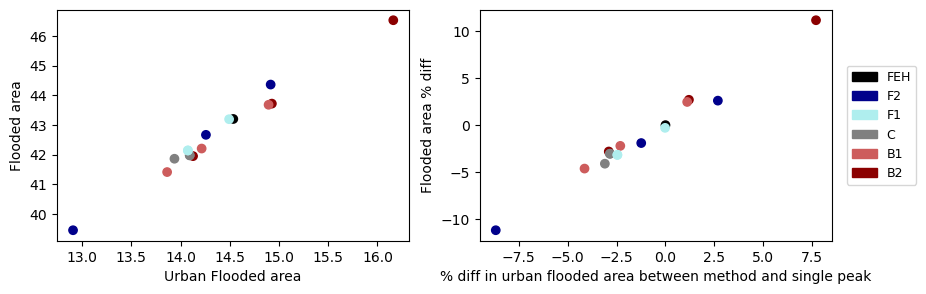

In [81]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,3))
# The urban flooded area as a percentage of the total area 
axs[0].scatter(cluster_results['UrbanFloodedArea'], cluster_results['TotalFloodedArea'], color = cluster_results['colour'])
axs[0].set_xlabel('Urban Flooded area')
axs[0].set_ylabel('Flooded area')
# (cluster_results['UrbanFloodedArea']/cluster_results['TotalFloodedArea'])*100
# The difference between the flooded area from a method and single peak 
axs[1].scatter(cluster_results['%Diff_FloodedArea_fromSP'], cluster_results['%Diff_UrbanFloodedArea_fromSP'],
              color = cluster_results['colour'])
axs[1].set_xlabel('% diff in urban flooded area between method and single peak')
axs[1].set_ylabel('Flooded area % diff');

colors = ['black','darkblue', 'paleturquoise', 'grey', 'indianred', 'darkred']
texts = ['FEH','F2','F1','C', 'B1', 'B2'] 
patches = [ mpatches.Patch(color=colors[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.14, 0.5), loc='center', ncol=1, prop={'size': 9} );

# Relationship between the total flooded area & the rainfall scenario used
One difference that might be expected to arise from the use of different rainfall scenarios is a difference in the total area which is flooded.  

The plots below display the total flooded area generated by each of the rainfall scenarios, and the percentage difference between each scenario and the FEH single peak scenario.  
*  In the first row of plots, the scenarios are ordered by the minute at which the maximum rainfall intensity occurs, with the most front loaded profiles towards the left. 
*  In the second row, the scenarios are ordered by the maximum rainfall intensity, with the scenarios with the highest intensities on the left. 

The relationship between the total flooded area and both the peak intensity and the minute of the peak intensity are also plotted for each scenario. This shows that there is a strong (?) positive relationship between the total flooded area and the magnitude of the peak intensity, and a weaker positive relationship between the minute of the peak intensity and the total flooded area. 

In [18]:
cluster_results['%Diff_FloodedArea_fromSP_formatted']=cluster_results['%Diff_FloodedArea_fromSP_formatted'].fillna('')

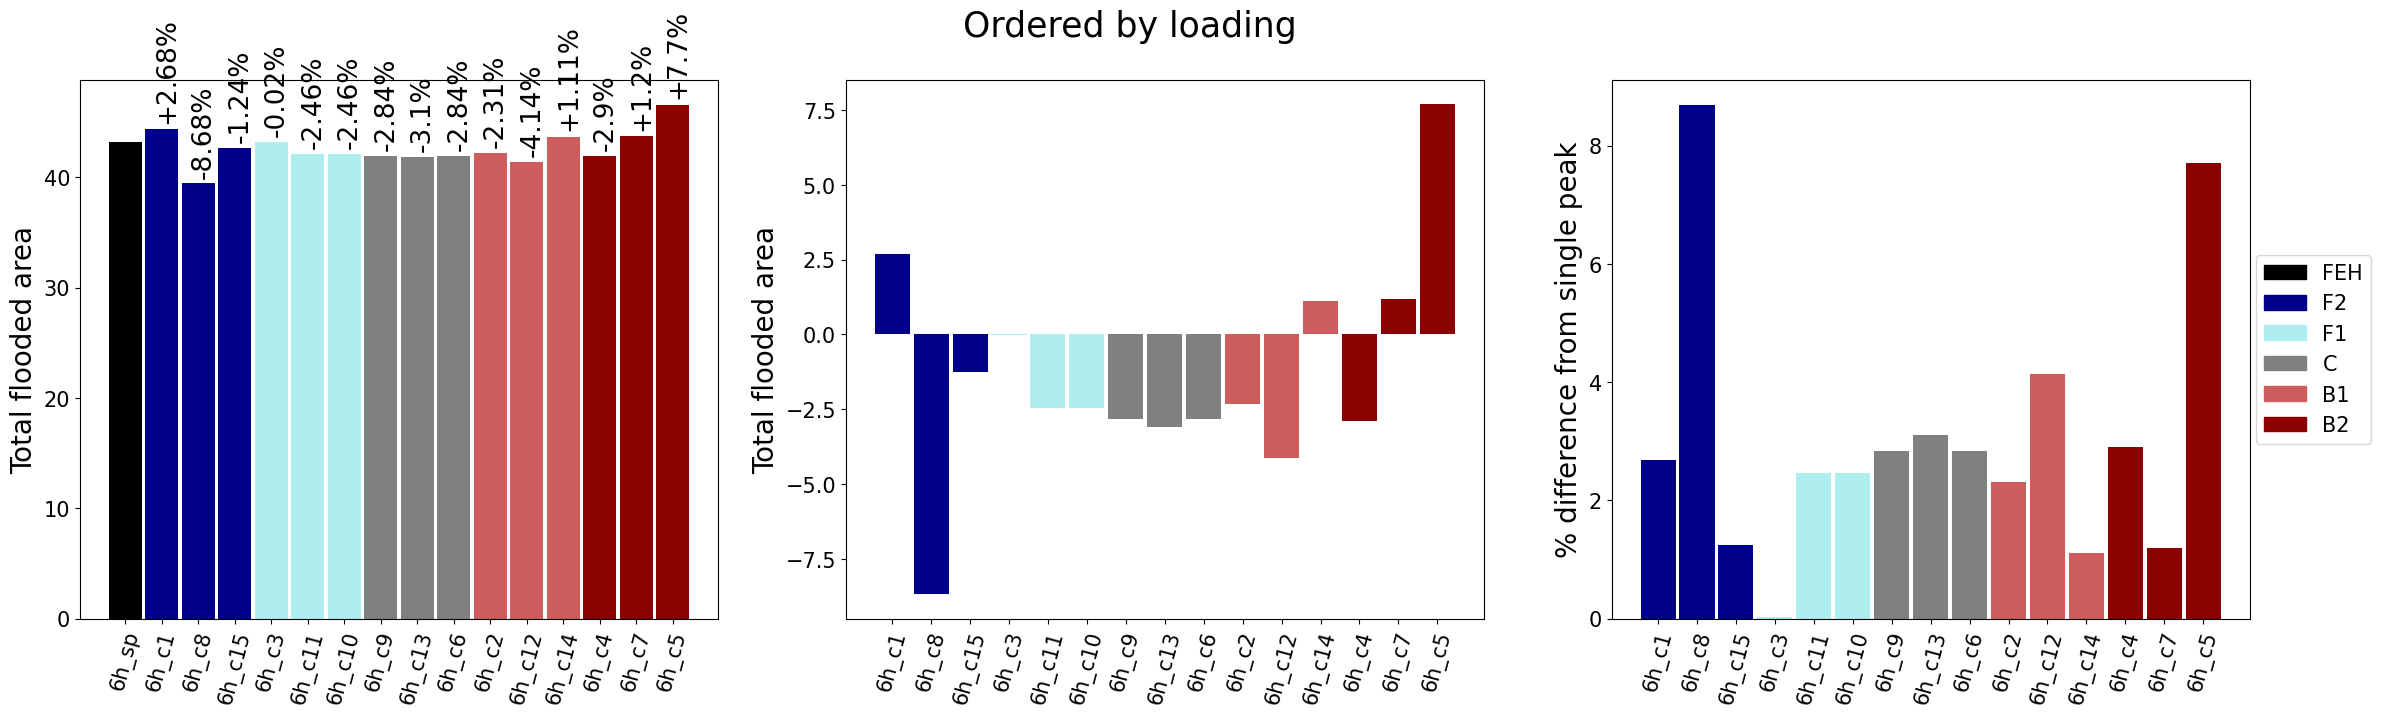

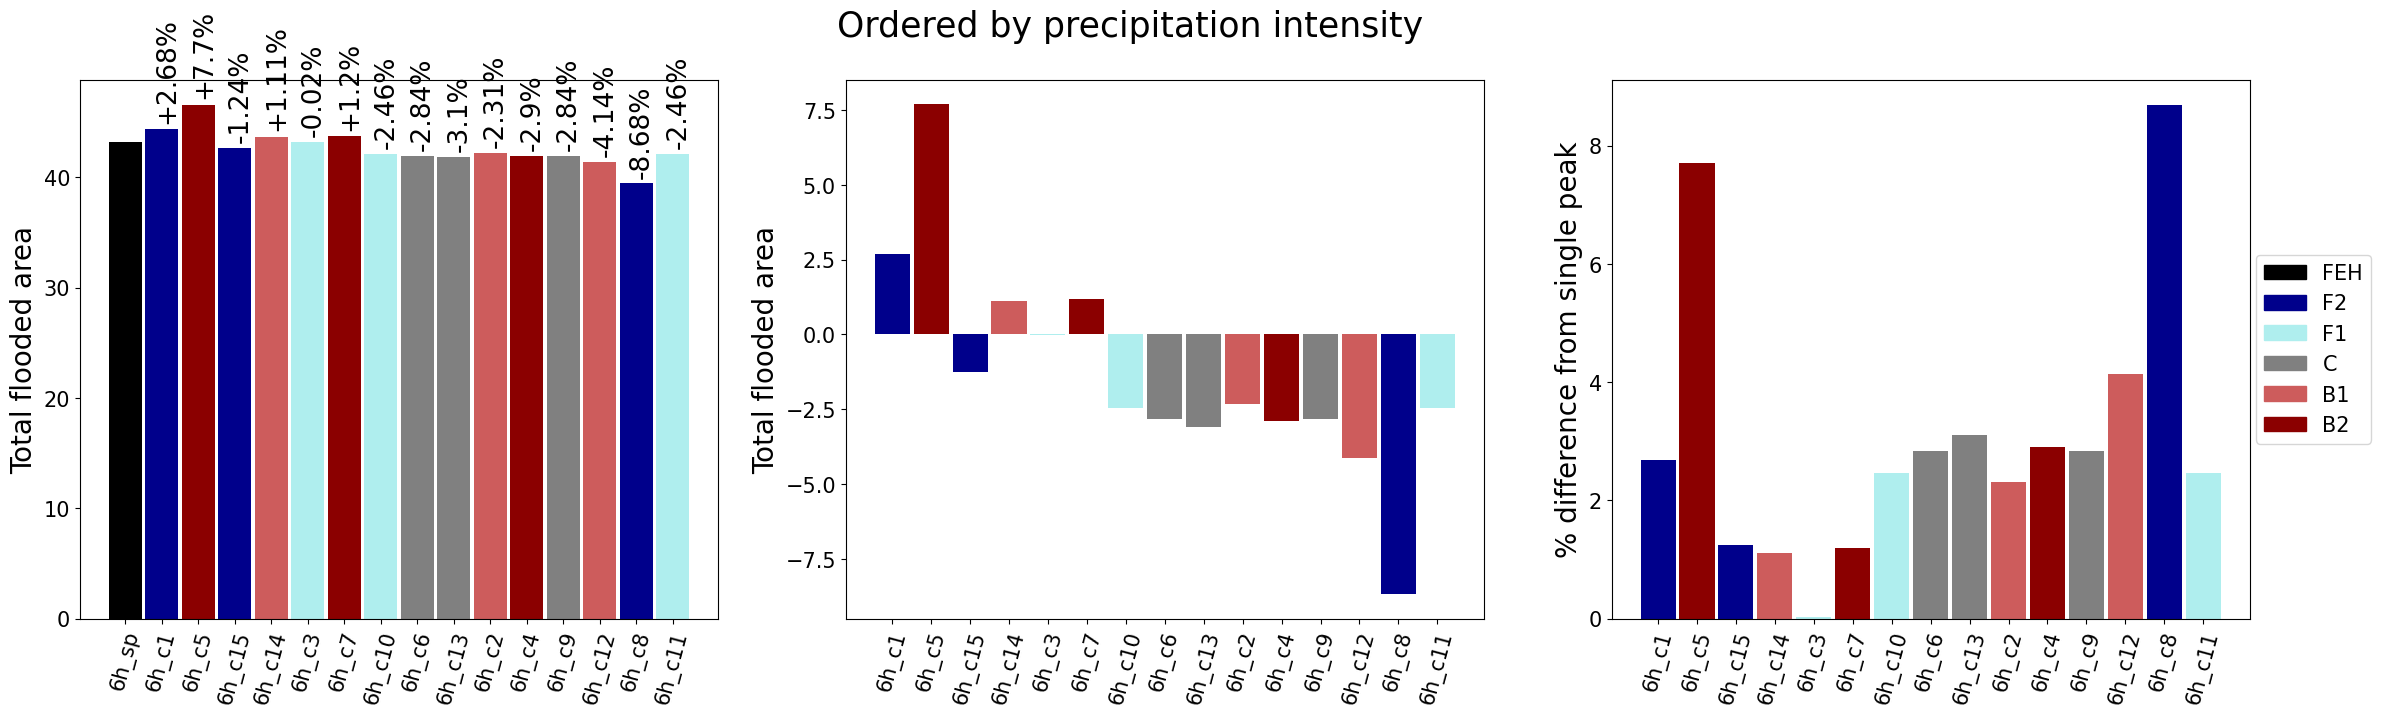

In [29]:
plot_totals(cluster_results, short_ids_by_loading, 'Ordered by loading')
plot_totals(cluster_results, short_ids_by_intensity, 'Ordered by precipitation intensity')

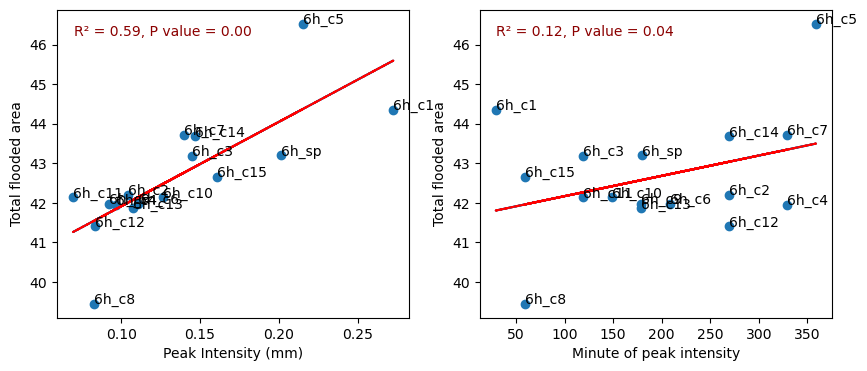

In [128]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,4))
scatter_plot_with_trend_line(axs[0], short_ids, cluster_results['MaxRainfallIntensity'], cluster_results['TotalFloodedArea'], 'Peak Intensity (mm)' , 'Total flooded area', add_r2 = True)
scatter_plot_with_trend_line(axs[1], short_ids, cluster_results['MaxRainfallIntensityMinute'], cluster_results['TotalFloodedArea'], 'Minute of peak intensity' , 'Total flooded area', add_r2 = True)

# Relationship between flood severity & the rainfall scenario used
### Plot the proportion of the total flooded cells in various depth/velocity categories
To test whether any of the scenarios lead to more severe flooding outcomes (within the same flooded extent)

In [21]:
velocity_props  =  reformat_counts_and_props(['<=0.25m/s_propcells','0.25-0.5m/s_propcells', '0.5-2m/s_propcells', '>2m/s_propcells'])        
velocity_props_urban  =  reformat_counts_and_props(['<=0.25m/s_propcells_urban','0.25-0.5m/s_propcells_urban', '0.5-2m/s_propcells_urban', '>2m/s_propcells_urban'])
velocity_counts  =  reformat_counts_and_props(['<=0.25m/s_countcells','0.25-0.5m/s_countcells', '0.5-2m/s_countcells', '>2m/s_countcells'])        
velocity_counts_urban  =  reformat_counts_and_props(['<=0.25m/s_countcells_urban','0.25-0.5m/s_countcells_urban', '0.5-2m/s_countcells_urban', '>2m/s_countcells_urban'])

depth_props  =  reformat_counts_and_props(['<=0.3m_propcells','0.3-0.6m_propcells', '0.6-1.2m_propcells', '>1.2m_propcells'])        
depth_props_urban  =  reformat_counts_and_props(['<=0.3m_propcells_urban','0.3-0.6m_propcells_urban', '0.6-1.2m_propcells_urban', '>1.2m_propcells_urban'])
depth_counts  =  reformat_counts_and_props(['<=0.3m_countcells','0.3-0.6m_countcells', '0.6-1.2m_countcells', '>1.2m_countcells'])        
depth_counts_urban  =  reformat_counts_and_props(['<=0.3m_countcells_urban','0.3-0.6m_countcells_urban', '0.6-1.2m_countcells_urban', '>1.2m_countcells_urban'])

In [24]:
colours_df = create_colours_df(short_ids_by_loading, short_ids)

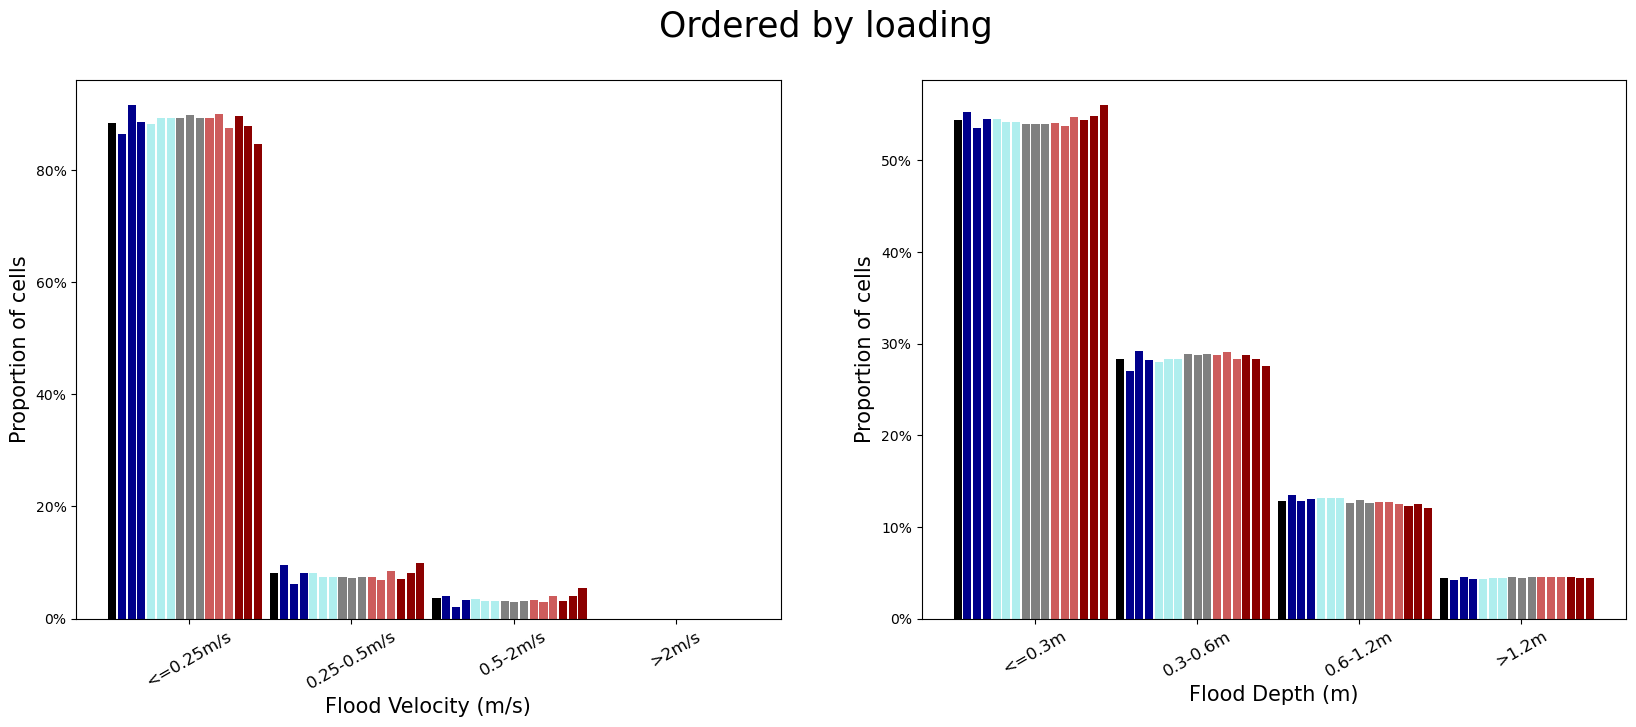

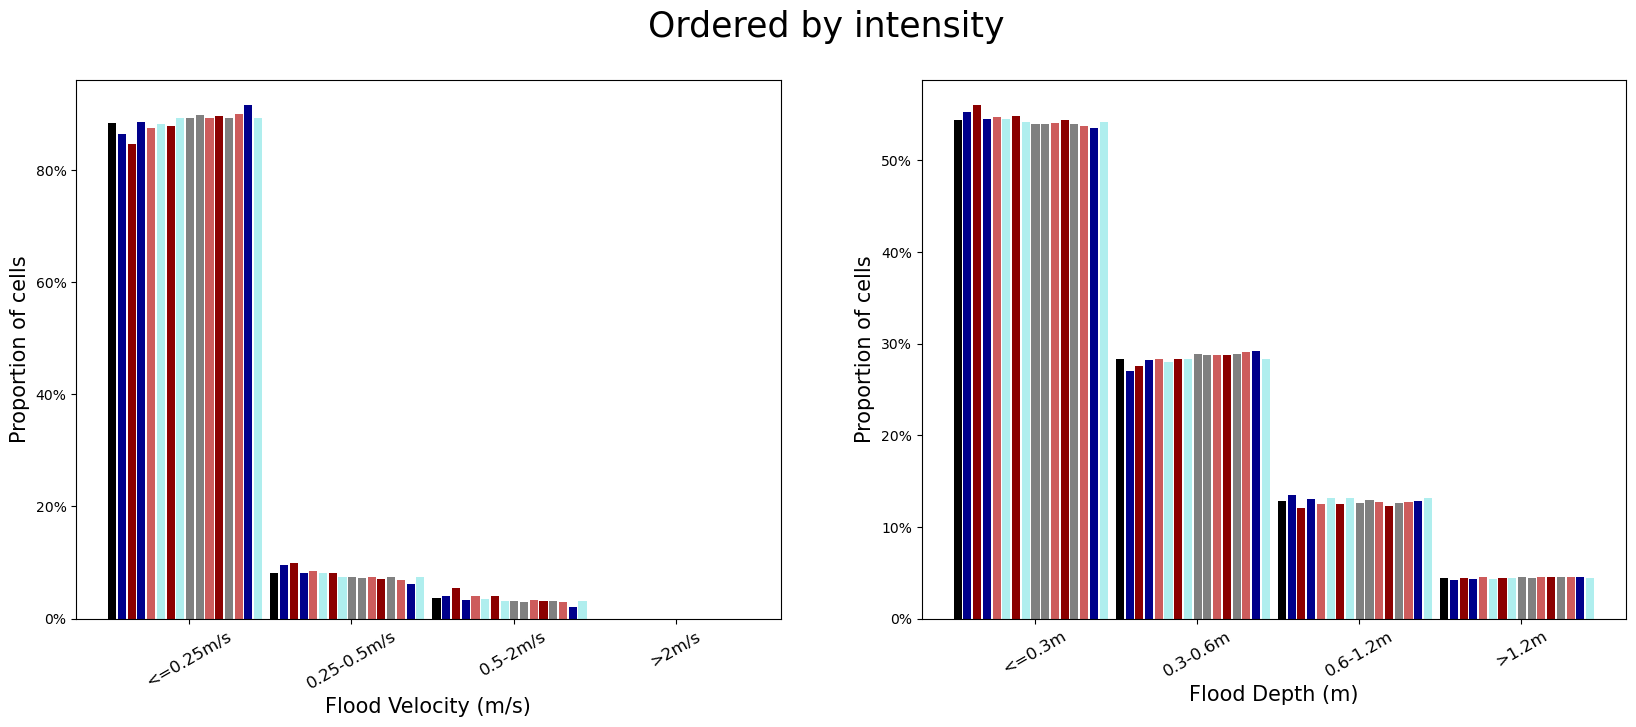

In [179]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (20,7))
bar_plot_props(axs[0],velocity_props, 'Velocity (m/s)',short_ids_by_loading, colours_df, 'Ordered by loading')
bar_plot_props(axs[1], depth_props, 'Depth (m)', short_ids_by_loading, colours_df, 'Ordered by loading')

fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (20,7))  
bar_plot_props(axs[0],velocity_props, 'Velocity (m/s)',short_ids_by_intensity,colours_df, 'Ordered by intensity')
bar_plot_props(axs[1], depth_props, 'Depth (m)', short_ids_by_intensity, colours_df, 'Ordered by intensity')

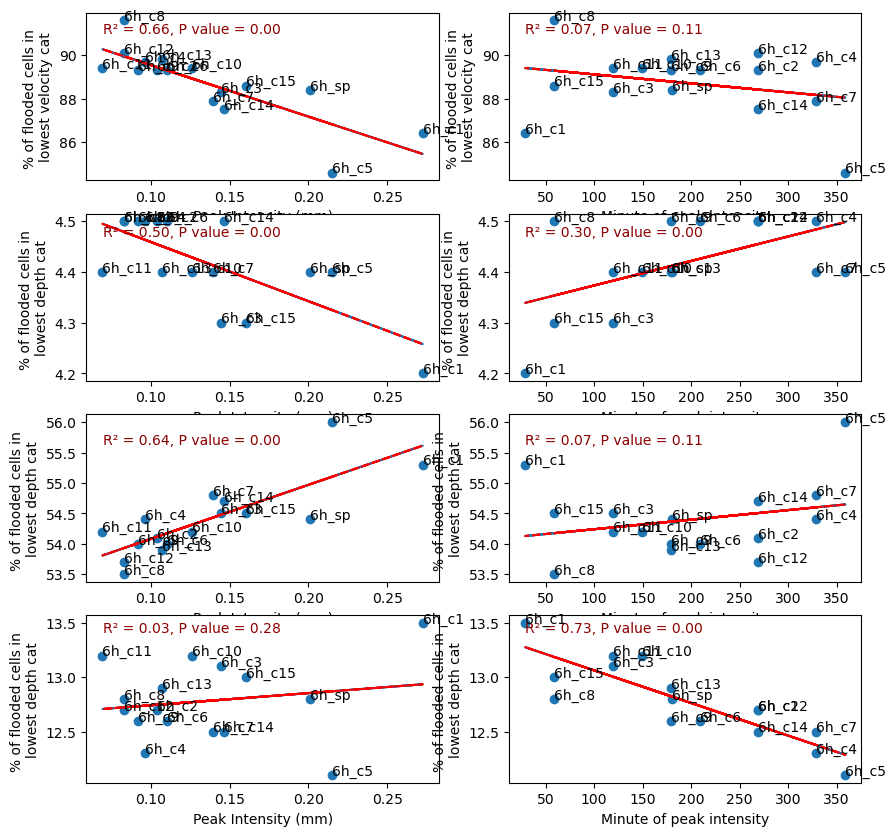

In [147]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize = (10,10))
scatter_plot_with_trend_line(axs[0,0], short_ids, cluster_results['MaxRainfallIntensity'], cluster_results['<=0.25m/s_propcells'], 'Peak Intensity (mm)' , '% of flooded cells in \nlowest velocity cat', add_r2 = True)
scatter_plot_with_trend_line(axs[0,1], short_ids, cluster_results['MaxRainfallIntensityMinute'], cluster_results['<=0.25m/s_propcells'], 'Minute of peak intensity' , '% of flooded cells in \nlowest velocity cat', add_r2 = True)

scatter_plot_with_trend_line(axs[1,0], short_ids, cluster_results['MaxRainfallIntensity'], cluster_results['>1.2m_propcells'], 'Peak Intensity (mm)' , '% of flooded cells in \nlowest depth cat', add_r2 = True)
scatter_plot_with_trend_line(axs[1,1], short_ids, cluster_results['MaxRainfallIntensityMinute'], cluster_results['>1.2m_propcells'], 'Minute of peak intensity' , '% of flooded cells in \nlowest depth cat', add_r2 = True)

scatter_plot_with_trend_line(axs[2,0], short_ids, cluster_results['MaxRainfallIntensity'], cluster_results['<=0.3m_propcells'], 'Peak Intensity (mm)' , '% of flooded cells in \nlowest depth cat', add_r2 = True)
scatter_plot_with_trend_line(axs[2,1], short_ids, cluster_results['MaxRainfallIntensityMinute'], cluster_results['<=0.3m_propcells'], 'Minute of peak intensity' , '% of flooded cells in \nlowest depth cat', add_r2 = True)

scatter_plot_with_trend_line(axs[3,0], short_ids, cluster_results['MaxRainfallIntensity'], cluster_results['0.6-1.2m_propcells'], 'Peak Intensity (mm)' , '% of flooded cells in \nlowest depth cat', add_r2 = True)
scatter_plot_with_trend_line(axs[3,1], short_ids, cluster_results['MaxRainfallIntensityMinute'], cluster_results['0.6-1.2m_propcells'], 'Minute of peak intensity' , '% of flooded cells in \nlowest depth cat', add_r2 = True)

## Method leading to deepest/fastest flooding in each cell

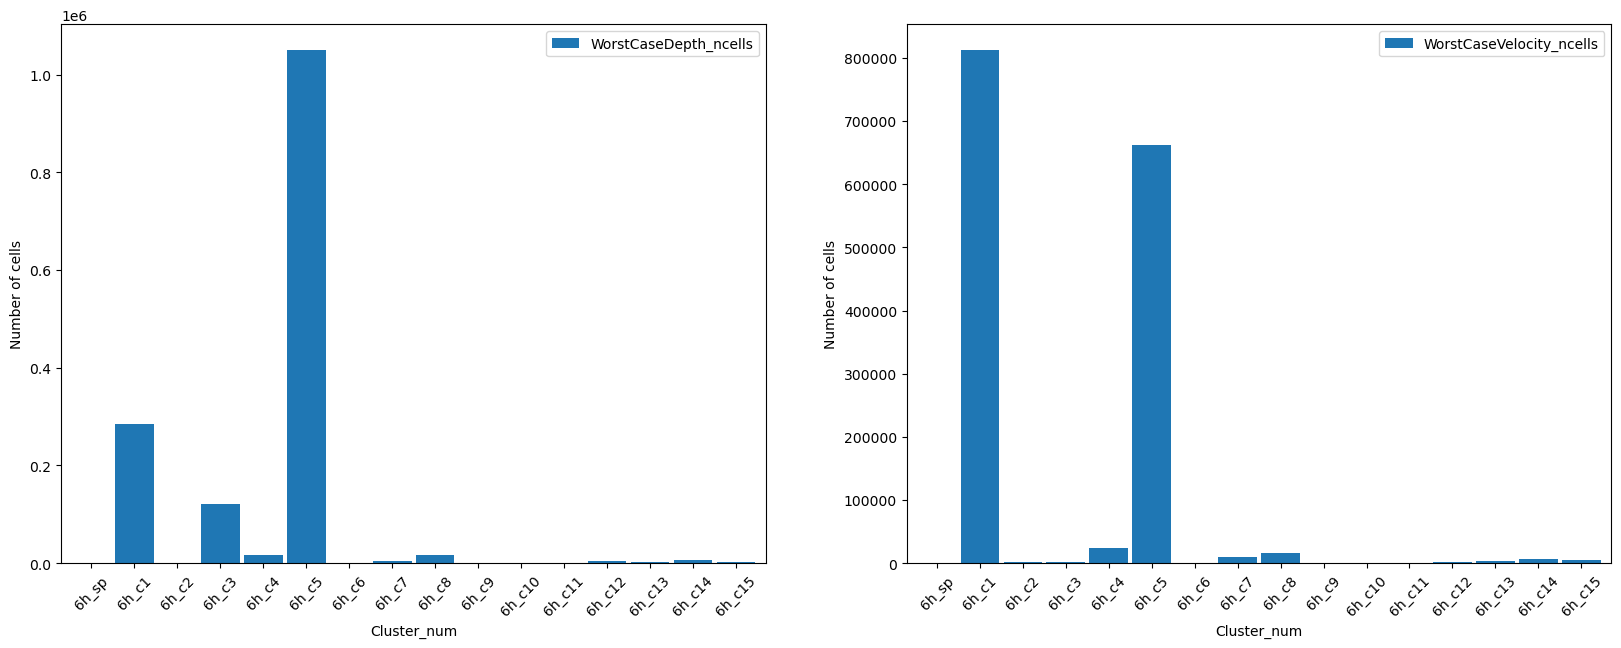

In [176]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (20,7))  
plot_worst_case_bars(axs[0], cluster_results, 'WorstCaseDepth_ncells')
plot_worst_case_bars(axs[1], cluster_results, 'WorstCaseVelocity_ncells')